In [1]:
import sys
sys.path.append('/home/xmax/projects/nn_ansatz/src')

from nn_ansatz import *
from nn_ansatz.vmc import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from jax import pmap
import pickle as pk



/home/xmax/anaconda3/envs/drop/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
# create the setup 
cfg = setup(system='LiSolid',
               n_walkers=128,
               n_layers=2,
               n_sh=32,
               n_ph=8,
               opt='kfac',
               n_det=4,
               print_every=1,
               save_every=5000,
               kappa = 1.,
               real_cut = 3,
               reciprocal_cut = 3)

key = rnd.PRNGKey(cfg['seed'])
keys = rnd.split(key, cfg['n_devices']).reshape(cfg['n_devices'], 2)

# create the molecule 
mol = SystemAnsatz(**cfg)

# create the wf
wf, vwf, kfac_wf, wf_orbitals = create_wf(mol)
params = initialise_params(key, mol)
d0s = initialise_d0s(mol, cfg['n_devices'], cfg['n_walkers_per_device'])

# create the potential energy 
# sampler, equilibrater = create_sampler(wf, vwf, mol, **cfg)
# walkers = mol.initialise_walkers(**cfg)
# walkers = equilibrater(params, walkers, d0s, keys, n_it=1000, step_size=0.02)
# with open('128walkers.pk', 'wb') as f:
#     pk.dump(walkers, f)
with open('128walkers.pk', 'rb') as f:
    walkers = pk.load(f)
# loop over cuts and plot the outcomes


step 500 energy -4.6255 acceptance 0.60
step 501 energy -4.9414 acceptance 0.60
step 502 energy -4.8054 acceptance 0.58
step 503 energy -5.1028 acceptance 0.61
step 504 energy -5.5551 acceptance 0.58
step 505 energy -4.4993 acceptance 0.59
step 506 energy -4.9196 acceptance 0.59
step 507 energy -5.1535 acceptance 0.58
step 508 energy -4.9187 acceptance 0.55
step 509 energy -4.9221 acceptance 0.63
step 510 energy -4.5752 acceptance 0.59
step 511 energy -4.4504 acceptance 0.62
step 512 energy -4.3021 acceptance 0.60
step 513 energy -4.6234 acceptance 0.59
step 514 energy -4.7212 acceptance 0.61
step 515 energy -4.6499 acceptance 0.61
step 516 energy -4.9459 acceptance 0.56
step 517 energy -4.7881 acceptance 0.57
step 518 energy -4.9421 acceptance 0.59
step 519 energy -4.4531 acceptance 0.61
step 520 energy -4.8915 acceptance 0.60
step 521 energy -4.9056 acceptance 0.56
step 522 energy -4.6490 acceptance 0.56
step 523 energy -5.1608 acceptance 0.57
step 524 energy -4.4927 acceptance 0.56


In [16]:

kappas = np.linspace(0.25, 2, 7)
real_cuts = np.arange(1, 7)
reciprocal_cuts = np.arange(1, 7)

energies = []
for kappa in kappas:
    mol.kappa = kappa
    for real_cut in real_cuts:
        mol.real_cut = real_cut
        real_lattice = generate_lattice(mol.real_basis, mol.real_cut)
        for reciprocal_cut in reciprocal_cuts:
            mol.reciprocal_cut = reciprocal_cut
            reciprocal_lattice = generate_lattice(mol.reciprocal_basis, mol.reciprocal_cut)
            pe_fn = pmap(create_potential_energy(mol, real_lattice, reciprocal_lattice), in_axes=(0, None, None))
            real, reciprocal, potential = pe_fn(walkers, mol.r_atoms, mol.z_atoms)
            results = [kappa, real_cut, reciprocal_cut, float(real.mean()), float(reciprocal.mean()), float(potential.mean())]
            energies.append(results)
            print(results)

data = pd.DataFrame(energies, columns=['kappa', 'real_cut', 'reciprocal_cut', 'real', 'reciprocal', 'potential'])


[0.25, 1, 1, -5.4146647453308105, 0.003000847529619932, -7.104232311248779]
[0.25, 1, 2, -5.4146647453308105, 0.0030008479952812195, -7.104232311248779]
[0.25, 1, 3, -5.4146647453308105, 0.0030008472967892885, -7.104232311248779]


KeyboardInterrupt: 

In [13]:
print(data)

    kappa  real_cut  reciprocal_cut      real  reciprocal  potential
0     0.5         1               1 -3.989404    0.270214  -7.104328
1     0.5         1               2 -3.989404    0.270309  -7.104232
2     0.5         2               1 -3.989404    0.270214  -7.104328
3     0.5         2               2 -3.989404    0.270309  -7.104232
4     1.0         1               1 -2.269024    1.727996  -7.311303
5     1.0         1               2 -2.269024    1.933002  -7.106297
6     1.0         2               1 -2.269024    1.727996  -7.311303
7     1.0         2               2 -2.269024    1.933002  -7.106297
8     1.5         1               1 -1.425223    3.068244  -8.512389
9     1.5         1               2 -1.425223    4.344198  -7.236435
10    1.5         2               1 -1.425223    3.068244  -8.512389
11    1.5         2               2 -1.425223    4.344198  -7.236435


kappa:  0.5


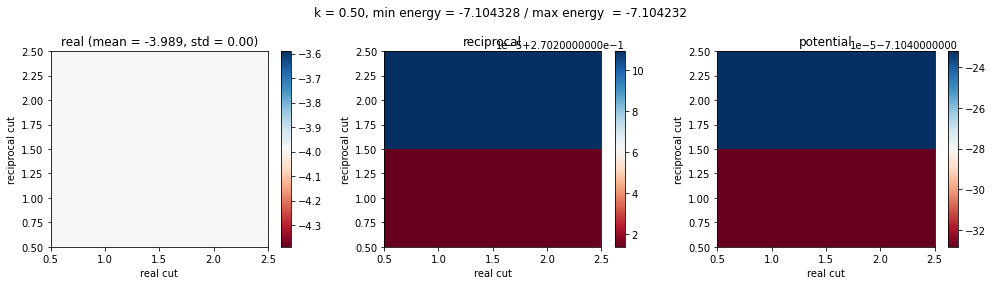

kappa:  1.0


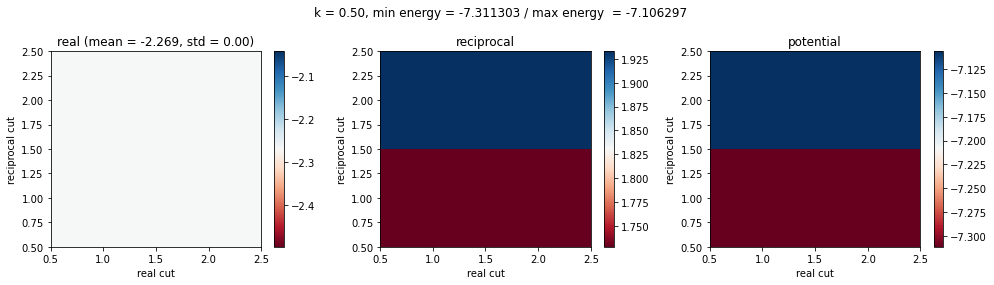

kappa:  1.5


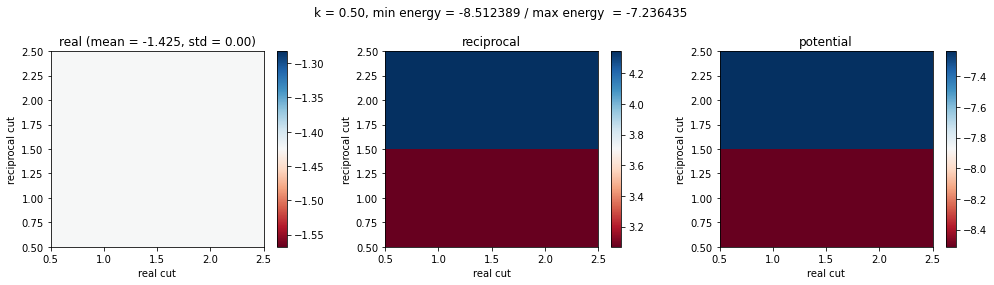

In [14]:

X, Y = np.meshgrid(real_cuts, reciprocal_cuts)

for kappa in kappas:
    print('kappa: ', kappa)
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    for z, ax in zip(['real', 'reciprocal', 'potential'], axs):
        plot_data = data[data.kappa == kappa].pivot(index='reciprocal_cut', columns='real_cut', values=z)
        p = ax.pcolor(X, Y, plot_data.values, cmap=cm.RdBu, vmin=plot_data.min().min(), vmax=plot_data.max().max(), shading='auto')
        ax.set_xlabel('real cut')
        ax.set_ylabel('reciprocal cut')
        if z == 'real': z = 'real (mean = %.3f, std = %.2f)' % (np.mean(plot_data.values), np.std(plot_data.values))
        ax.set_title(z)
        cb = fig.colorbar(p, ax=ax)
    fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (k, plot_data.min().min(), plot_data.max().max()))
    fig.tight_layout()
        
    plt.show()

In [17]:







def create_potential_energy(mol, real_lattice, reciprocal_lattice):
    """

    Notes:
        - May need to shift the origin to the center to enforce the spherical sum condition
        - I am now returning to length of unit cell units which is different to the unit cell length I was using before. How does this affect the computation?
        - Is the reciprocal height computed in the correct way?
    """
    if mol.periodic_boundaries:
        
        real_basis = mol.real_basis
        reciprocal_basis = mol.reciprocal_basis
        kappa = mol.kappa
        volume = mol.volume

          # (n_lattice, 3)
        rl_inner_product = inner(reciprocal_lattice, reciprocal_lattice)
        rl_factor = (4*jnp.pi / volume) * jnp.exp(- rl_inner_product / (4*kappa**2)) / rl_inner_product  

        e_charges = jnp.array([-1. for i in range(mol.n_el)])
        charges = jnp.concatenate([mol.z_atoms, e_charges], axis=0)  # (n_particle, )
        q_q = charges[None, :] * charges[:, None]  # q_i * q_j  (n_particle, n_particle)

        def compute_potential_energy_solid_i(walkers, r_atoms, z_atoms):

            """
            :param walkers (n_el, 3):
            :param r_atoms (n_atoms, 3):
            :param z_atoms (n_atoms, ):

            Pseudocode:
                - compute the potential energy (pe) of the cell
                - compute the pe of the cell electrons with electrons outside
                - compute the pe of the cell electrons with nuclei outside
                - compute the pe of the cell nuclei with nuclei outside
            """

            # put the walkers and r_atoms together
            walkers = jnp.concatenate([r_atoms, walkers], axis=0)  # (n_particle, 3)

            # compute the Rs0 term
            p_p_vectors = vector_sub(walkers, walkers)
            p_p_distances = compute_distances(walkers, walkers)
            # p_p_distances[p_p_distances < 1e-16] = 1e200  # doesn't matter, diagonal dropped, this is just here to suppress the error
            Rs0 = jnp.tril(erfc(kappa * p_p_distances) / p_p_distances, k=-1)  # is half the value

            # compute the Rs > 0 term
            ex_walkers = vector_add(walkers, real_lattice)  # (n_particle, n_lattice, 3)
            tmp = walkers[:, None, None, :] - ex_walkers[None, ...]  # (n_particle, n_particle, n_lattice, 3)
            ex_distances = jnp.sqrt(jnp.sum(tmp**2, axis=-1))  
            Rs1 = jnp.sum(erfc(kappa * ex_distances) / ex_distances, axis=-1)
            real_sum = (q_q * (Rs0 + 0.5 * Rs1)).sum((-1, -2))
            
            # compute the constant factor
            self_interaction = - 0.5 * jnp.diag(q_q * 2 * kappa / jnp.sqrt(jnp.pi)).sum()
            constant = - 0.5 * charges.sum()**2 * jnp.pi / (kappa**2 * volume)  # is zero in neutral case

            # compute the reciprocal term reuse the ee vectors
            exp = jnp.real(jnp.sum(rl_factor[None, None, :] * jnp.exp(1j * p_p_vectors @ jnp.transpose(reciprocal_lattice)), axis=-1))
            reciprocal_sum = 0.5 * (q_q * exp).sum((-1,-2))
            
            potential = real_sum + reciprocal_sum + constant + self_interaction
            # return potential
            return real_sum, reciprocal_sum, potential

        return vmap(compute_potential_energy_solid_i, in_axes=(0, None, None))

    return vmap(compute_potential_energy_i, in_axes=(0, None, None))